# [Lecture 02 - The Garden of Forking Data](https://youtu.be/R1vcdhPBlXA?si=rL3BOz9hHxkPt79m)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-06-23T12:45:37.278182-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.25.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

numpy      : 1.24.4
statsmodels: 0.14.0
matplotlib : 3.8.4
xarray     : 2024.6.0
arviz      : 0.18.0
scipy      : 1.13.1
pandas     : 2.2.2
pymc       : 5.8.0



# Task: What proportion of earth's surface is covered with water?

## Workflow (Drawing the Owl)

1. Define **generative model** of tossing the globe
2. Define an **estimand** -- in this case, the proportion of globe covered in water
3. **Design a statistical procedure** to produce an estimate of the estimand
4. **Validate the statistical procedure** (3) using the generative model -- can we recover an accurate estimate of (2) from data generated by (1)
5. **Apply statistical procedure** (3) to real data

## 1, 2. Define generative model of globe tossing
- $p$: proportion of water -- this is the **estimand**, what we'd like to estimate
- $N$: number of tosses  -- we control this via experiment
- $W$: number of `Water` observations
- $L$: number of `Land` observations

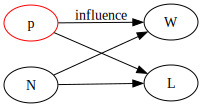

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("p", "L"),
        ("N", "L"),
        ("N", "W")
    ],
    graph_direction="LR",
    node_props={
        "p": {"color": "red"}
    },
    edge_props={
        ("p", "W"): {"label": "influence"}
    }
)

- This graph defines a causal model, of how $p, N$ effect the values of $W, L$. This is the same as saying it defines some function $f$ that maps $p, N$ onto the values of $W, L$, i.e.  $W, L = f(p, N)$
- Scientific knowledge defines what $f$ is or can be

The unglamourous basis of applied probability:
> **Things that can happen more ways are more plausible.**


#### Bayesian data analysis
"Very simple, very humble"
- For each possible explanation of the sample
- Count all the ways the sample could occur
- **The explanations with the largest number of ways to produce the observed sample are more plausible**


## 3. Design a statistical procedure to produce an estimate
### Garden of Forking Data
Following the mantra above...

- for each possible **proportion of water**, $p$
- count all the ways the sample of tosses could have occurred
- the $p$ that are associated with more ways to produce the sample are more plausible


In [3]:
def calculate_n_ways_possible(observations: str, n_water: int, resolution: int = 4):
    """
    Calculate the number of ways to observing water ('W') given the toss of a globe
    with `resolution` number of sides and `n_water` faces.
    
    Note: this method results in numerical precision issues (due to the product) when the
    resolution of 16 or so, depending on your system.
    """
    assert n_water <= resolution
    
    # Convert observation string to an array
    observations = np.array(list(observations.upper()))
    
    # Create n-sided globe with possible outcomes
    possible = np.array(list("L" * (resolution - n_water)) + list("W" * n_water))
    
    # Tally up ways to obtain each observation given the possible outcomes
    # Here we use brute-force, but we could also use the analytical solution below
    ways = []
    for obs in observations:
        ways.append((possible == obs).sum())
    
    p_water = n_water / resolution
    # perform product in log space for numerical precision
    n_ways = np.round(np.exp(np.sum(np.log(ways)))).astype(int)
    return n_ways, p_water


def run_globe_tossing_simulation(observations, resolution, current_n_possible_ways=None):
    """Simulate the number of ways you can observe water ('W') for a globe of `resolution`
    sides, varying the proportion of the globe that is covered by water.
    """
    # For Bayesian updates
    current_n_possible_ways = current_n_possible_ways if current_n_possible_ways is not None else np.array([])
    
    print(f"Observations: '{observations}'")
    p_water = np.array([])
    for n_W in range(0, resolution + 1):
        n_L = resolution - n_W
        globe_sides = "W" * n_W + "L" * n_L
        n_possible_ways, p_water_ = calculate_n_ways_possible(observations, n_water=n_W, resolution=resolution)
        print(f"({n_W+1}) {globe_sides} p(W) = {p_water_:1.2}\t\t{n_possible_ways} Ways to Produce")

        p_water = np.append(p_water, p_water_)
        current_n_possible_ways = np.append(current_n_possible_ways, n_possible_ways)

    return current_n_possible_ways, p_water


RESOLUTION = 4
observations = "WLW"
n_possible_ways, p_water = run_globe_tossing_simulation(observations, resolution=RESOLUTION)

Observations: 'WLW'
(1) LLLL p(W) = 0.0		0 Ways to Produce
(2) WLLL p(W) = 0.25		3 Ways to Produce
(3) WWLL p(W) = 0.5		8 Ways to Produce
(4) WWWL p(W) = 0.75		9 Ways to Produce
(5) WWWW p(W) = 1.0		0 Ways to Produce


## Bayesian (online) Updating

In [4]:
new_observation_possible_ways, _ = run_globe_tossing_simulation("W", resolution=RESOLUTION)

# Online update
n_possible_ways *= new_observation_possible_ways

print("\nUpdated Possibilities given new observation:")
for ii in range(0, RESOLUTION + 1):    
    print(f"({ii+1}) p(W) = {p_water[ii]:1.2}\t\t{int(n_possible_ways[ii])} Ways to Produce")


Observations: 'W'
(1) LLLL p(W) = 0.0		0 Ways to Produce
(2) WLLL p(W) = 0.25		1 Ways to Produce
(3) WWLL p(W) = 0.5		2 Ways to Produce
(4) WWWL p(W) = 0.75		3 Ways to Produce
(5) WWWW p(W) = 1.0		4 Ways to Produce

Updated Possibilities given new observation:
(1) p(W) = 0.0		0 Ways to Produce
(2) p(W) = 0.25		3 Ways to Produce
(3) p(W) = 0.5		16 Ways to Produce
(4) p(W) = 0.75		27 Ways to Produce
(5) p(W) = 1.0		0 Ways to Produce


## The whole sample

In [5]:
RESOLUTION = 4
observations = "WLWWWLWLW"
n_W = len(observations.replace("L", ""))
n_L = len(observations) - n_W

n_possible_ways, p_water = run_globe_tossing_simulation(observations, resolution=RESOLUTION)

Observations: 'WLWWWLWLW'
(1) LLLL p(W) = 0.0		0 Ways to Produce
(2) WLLL p(W) = 0.25		27 Ways to Produce
(3) WWLL p(W) = 0.5		512 Ways to Produce
(4) WWWL p(W) = 0.75		729 Ways to Produce
(5) WWWW p(W) = 1.0		0 Ways to Produce


show that we get identical answers with the analytical solution

#### Results suggest the Analytical Solution $W,L = (Rp)^W \times (R - Rp)^L$
where $R$ is the number of possible globes, in this case 4

In [6]:
def calculate_analytic_n_ways_possible(p, n_W, n_L, resolution=RESOLUTION):
    """This scales much better than the brute-force method"""
    return (resolution * p) ** n_W * (resolution - resolution * p) ** n_L

analytic_n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L) for p in p_water])
assert (analytic_n_possible_ways == n_possible_ways).all()

## Probability
- non-negative values that sum to 1
- normalizes large sums by the total counts

Proportion	Ways	Probability
0.0		0	0.00
0.25		27	0.02
0.5		512	0.40
0.75		729	0.57
1.0		0	0.00


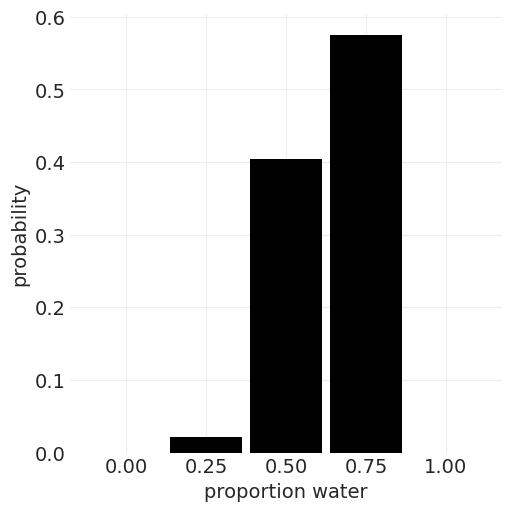

In [7]:
n_possible_probabilities = n_possible_ways / n_possible_ways.sum()

print("Proportion\tWays\tProbability")
for p, n_w, n_p in zip(p_water, n_possible_ways, n_possible_probabilities):
    print(f"{p:1.12}\t\t{n_w:0.0f}\t{n_p:1.2f}")

probs = np.linspace(0, 1, RESOLUTION+1)
plt.subplots(figsize=(5, 5))
plt.bar(x=probs, height=n_possible_probabilities, width= .9 / RESOLUTION, color='k')
plt.xticks(probs);
plt.ylabel("probability")
plt.xlabel("proportion water");

## 4. Validate Statistical Procedure (3) using Generative Model (1)

### Test Before You Est(imate) 🐤
1. Code generative simulation (1)
2. Code an estimator (3)
3. Test (3) with (1); you should get expected output

**IF YOU TEST NOTHING YOU MISS EVERYTHING**



### 4.1 Generative Simulation

In [8]:
from pprint import pprint
np.random.seed(1)
def simulate_globe_toss(p: float = 0.7, N: int = 9) -> list[str]:
    """Simulate N globe tosses with a specific/known proportion
    p: float
        The propotion of water
    N: int
        Number of globe tosses
    """
    return np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)

In [9]:
print(simulate_globe_toss())

['W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W']


In [10]:
pprint([simulate_globe_toss(p=1, N=11).tolist() for _ in range(10)])

[['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']]


#### Test on Extreme settings
With a large number of samples N, estimator should converge to known $p$

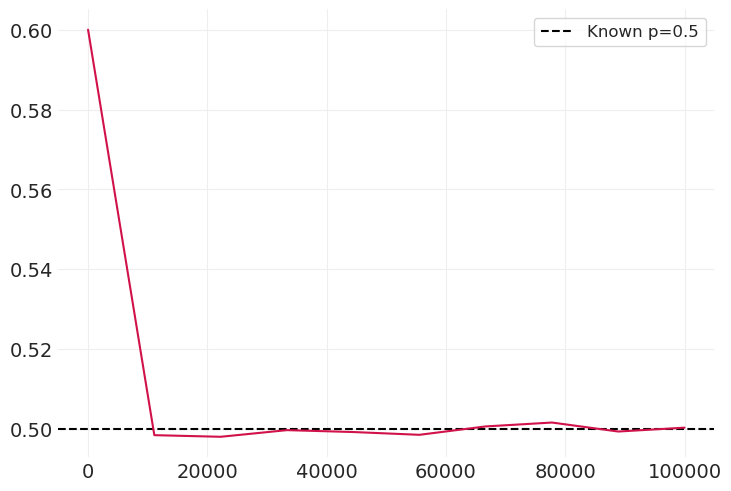

In [11]:
known_p = 0.5

simulated_ps = []
sample_sizes = np.linspace(10, 100_000, 10)
for N in sample_sizes:
    simulated_p = np.sum(simulate_globe_toss(p=known_p, N=int(N)) == 'W') / N
    simulated_ps.append(simulated_p)
    
plt.axhline(known_p, label=f"Known p={known_p}", color='k', linestyle='--')
plt.legend();
plt.plot(sample_sizes, simulated_ps);

### 4.2 Code the estimator

The estimator takes in observations and returns a probability distribution (posterior) over potential estimates. Higher probability estimates should be more plausible given the data.

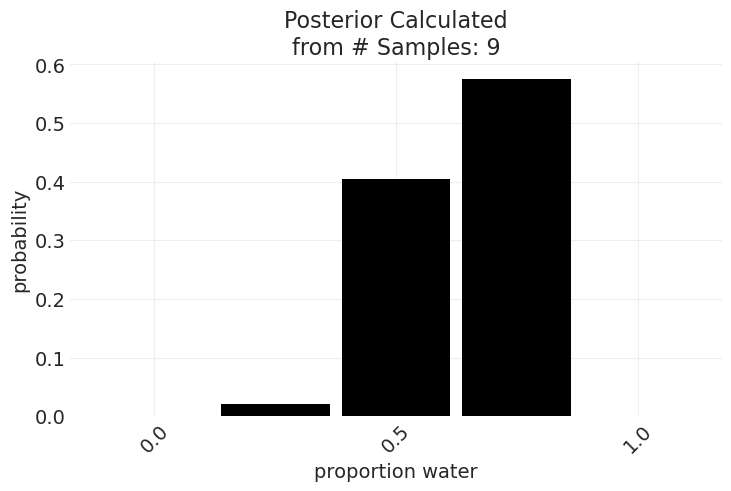

In [12]:
def compute_posterior(observations, resolution=RESOLUTION, ax=None):
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    
    p_water = np.linspace(0, 1, resolution + 1)
    n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L, resolution) for p in p_water])

    posterior = n_possible_ways / n_possible_ways.sum()
    potential_p = np.linspace(0, 1, resolution + 1)
    
    return posterior, potential_p

def plot_posterior(observations, resolution=RESOLUTION, ax=None):
    posterior, probs = compute_posterior(observations, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=probs, height=posterior, width= .9 / resolution, color='k')
    plt.xticks(probs[::2], rotation=45);
    plt.ylabel("probability")
    plt.xlabel("proportion water")
    plt.title(f"Posterior Calculated\nfrom # Samples: {len(observations)}")
    
plot_posterior(observations, resolution=4)

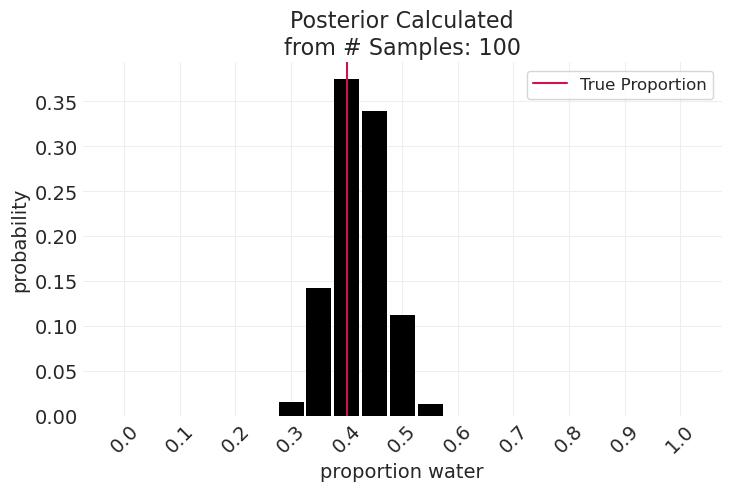

In [13]:
np.random.seed(2)
known_p = .4
simulated_observations = "".join(simulate_globe_toss(p=known_p, N=100))
plot_posterior(simulated_observations, resolution=20)
plt.axvline(known_p, color='C0', label='True Proportion')
plt.legend();

## Infinite Possibilities

### Moving from an N-sided globe to an infinitely-sided globe.
As we increase resolution of globe
- there are more bars/finer-grained resolution along the proportion axis
- bars get shorter with more possibilities -- they must sum to 1

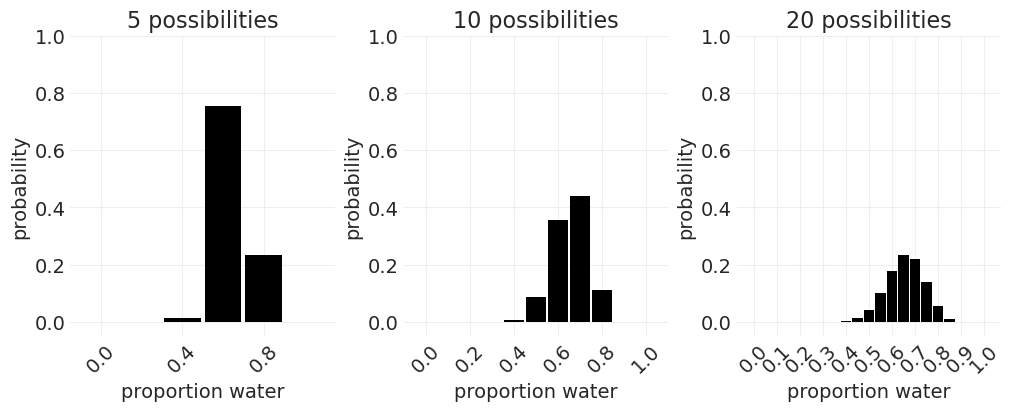

In [14]:
np.random.seed(12)
known_p = .7
simulated_observations = "".join(simulate_globe_toss(p=known_p, N=30))
_, axs = plt.subplots(1, 3, figsize=(10, 4))
for ii, possibilities in enumerate([5, 10, 20]):
    plot_posterior(simulated_observations, resolution=possibilities, ax=axs[ii])
    plt.ylim([-.05, 1])
    axs[ii].set_title(f"{possibilities} possibilities")

### Beta Distribution

Analytical function that gives us the pdf as the limit as number of possibilities $\rightarrow \infty$

$$
p = \frac{(W + L + 1)!}{W!L!} p^W(1-p)^L
$$

where $\frac{(W + L + 1)!}{W!L!}$ is a normalizing constant to make the distribution sum to 1



### Tossing the Globe

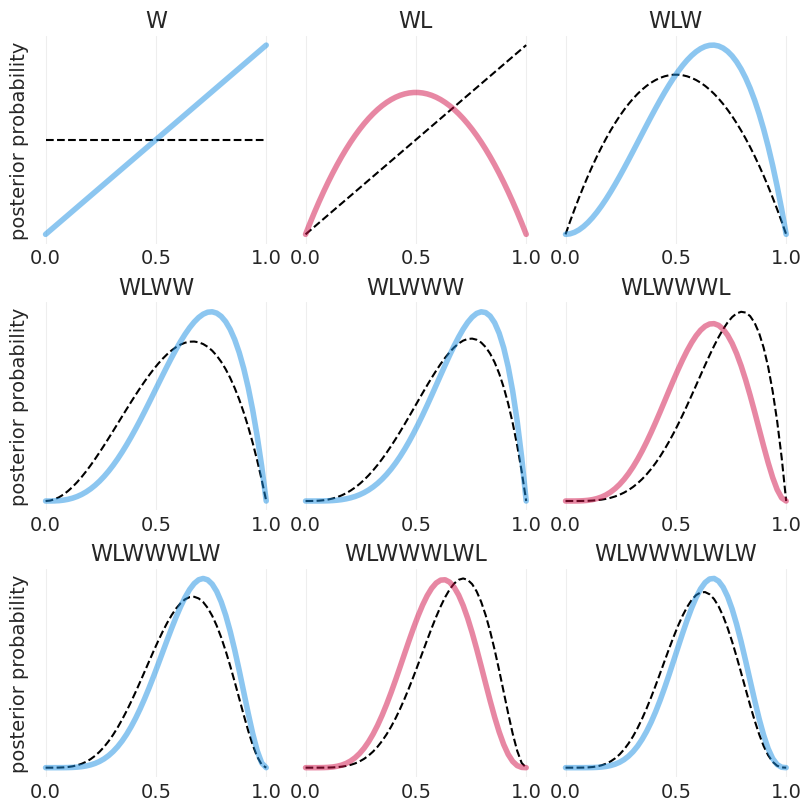

In [26]:
from scipy.special import factorial

def beta_posterior(n_W: int, n_L: int, p: float) -> float:
    """Calculates the beta posterior over proportions `p` given a set of
    `N_W` water and `N_L` land observations
    """
    return factorial(n_W + n_L + 1) / (factorial(n_W) * factorial(n_L)) * p ** n_W * (1-p) ** n_L


def plot_beta_posterior_from_observations(observations: str, resolution: int = 50, **plot_kwargs) -> None:
    """Calculates and plots the beta posterior for a string of observations"""
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    proportions = np.linspace(0, 1, resolution)
        
    probs = beta_posterior(n_W, n_L, proportions)
    plt.plot(proportions, probs, **plot_kwargs)
    plt.yticks([])
    plt.title(observations)
    

# Tossing the globe
observations = "WLWWWLWLW"
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ii in range(9):
    ax = axs[ii // 3][ii % 3]
    plt.sca(ax)
    # Plot previous
    if ii > 0:
        plot_beta_posterior_from_observations(observations[:ii], color='k', linestyle='--')
    else:
        # First observation, no previous data
        plot_beta_posterior_from_observations('', color='k', linestyle='--')
        
    color = 'C1' if observations[ii] == 'W' else 'C0'
    plot_beta_posterior_from_observations(observations[:ii+1], color=color, linewidth=4, alpha=.5)
    
    if not ii % 3:
        plt.ylabel("posterior probability")
    

## On Bayesian Inference...
- **There is no minimun sample size** -- fewer samples fall back to prior
- **Posterior shape embodies the sample size** -- more data makes the posterior more precise
- There is no point estimates -- **the estimate is the entire posterior distribution**
- There is no true interval -- there are an infinite number of intervals one could draw, each is arbitrary and depends on what you're trying to communicate/summarize

## From Posterior to Prediction
- To make predictions, we must average (i.e. integrate) over the entire posterior -- this averages over the uncertainty in the posterior
- We could do this with integral calculus
- OR, we could just **take samples from the posterior and average over those**

**TURN A CALCULUS PROBLEM INTO A DATA SUMMARY PROBLEM**

### Sampling from Posterior Distribution

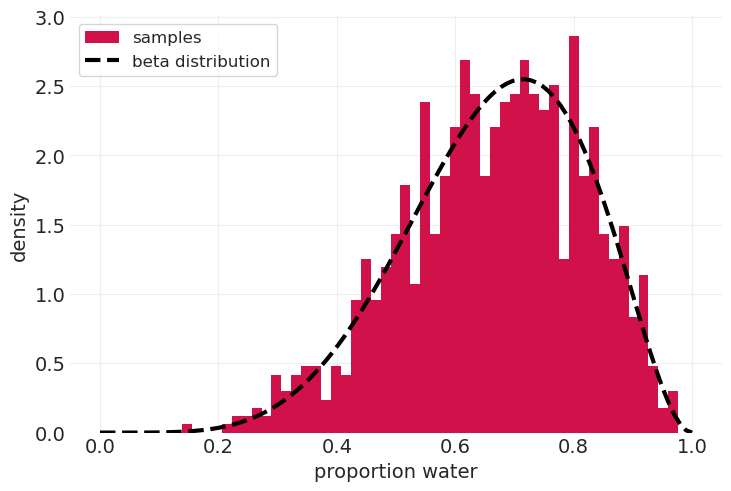

In [27]:
a, b = 6, 3
# draw random samples from Beta PDF
beta_posterior_pdf = stats.beta(a, b)
beta_posterior_samples = beta_posterior_pdf.rvs(size=1000)

# Show that our beta postorior captures shape of beta-distributed samples
plt.hist(beta_posterior_samples, bins=50, density=True, label='samples');
probs = np.linspace(0, 1, 100)
plt.plot(probs, beta_posterior(a-1, b-1, probs), linewidth=3, color='k', linestyle='--', label='beta distribution')
plt.xlabel("proportion water")
plt.ylabel("density")
plt.legend();

### Sampling from Posterior Predictive Distribution
**Posterior Prediction**: a prediction for out-of-sample data based on the current posterior estimate
- 1. Draw a sample of model parameters from the posterior (i.e. proportions)
- 2. Generate/simulate data predictions using our generative model and the sampled parameters
- 3. The resulting probability distribution is our prediction

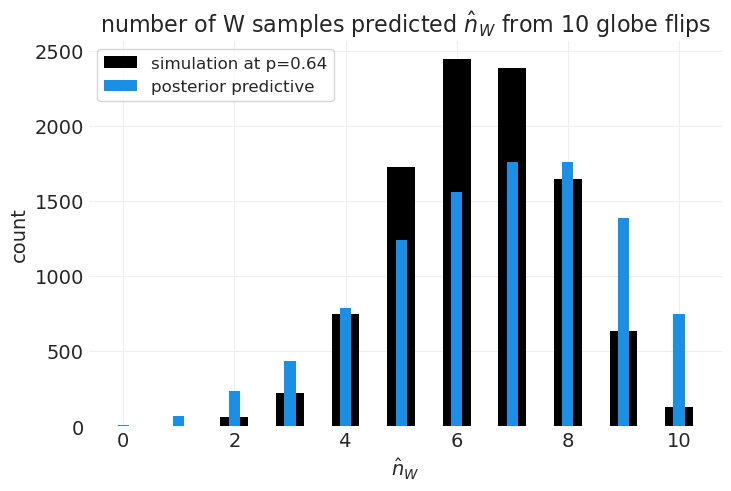

In [36]:
# 1. Sample parameters values from posterior
N_posterior_samples = 10_000
posterior_samples = beta_posterior_pdf.rvs(size=N_posterior_samples)

# 2. Use samples for the posterior to simulate sampling 10 observations from our generative model
N_draws_for_prediction = 10
posterior_predictive = [(simulate_globe_toss(p, N_draws_for_prediction) == 'W').sum() for p in posterior_samples]
ppd_unique, ppd_counts = np.unique(posterior_predictive, return_counts=True)

# ...for comparison we can compare to the distribution that results from pinning the parameter to a specific value
specific_prob = 0.64
specific_predictive = [(simulate_globe_toss(specific_prob, N_draws_for_prediction) == 'W').sum() for _ in posterior_samples]
specific_unique, specific_counts = np.unique(specific_predictive, return_counts=True)

plt.bar(specific_unique, specific_counts, width=.5, color='k', label=f'simulation at p={specific_prob:1.2}');
plt.bar(ppd_unique, ppd_counts, width=.2, color='C1', label='posterior predictive');
plt.xlabel("$\hat n_W$")
plt.ylabel('count')
plt.title(f"number of W samples predicted $\hat n_W$ from {N_draws_for_prediction} globe flips")
plt.legend();


### Sampling is Handsom & Handy
Things we'll compute via sampling
- Forecasts
- Causal effects
- Counterfactuals
- Prior Predictions

# Summary: Bayesian Data Analysis
- For each possible explanation of data
- Count all the ways that data could occur under that explanation
- The explanations with more ways to produce data are more plausable

## Bayesian Modesty
- If your generative model is correct, you can't do better: this will be an optimal solution
- Gives no gaurantees, only provides what you put into it

# Bonus: Misclassification
In previous examples, we  do not consider sampling error or noise in measurement. In other words the number of `Water` observations that we measure may not be the _true_ value.

This means that the _true_ value for $W$ is unknown / unmeasured, but we instead measure $W^*$ that is caused by both the true, unmeasured $W$ and the measurement process $M$. If we know our measurement error rate, we can attempt to model it

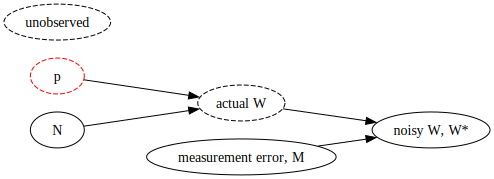

In [38]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("W", "W*"),
        ("M", "W*"),
        ("N", "W")
    ],
    node_props={
        "p": {"color": "red", "style": "dashed"},
        "W": {"style": "dashed", "label": "actual W"},
        "W*": {"label": "noisy W, W*"},
        "unobserved": {"style": "dashed"},
        "M": {"label": "measurement error, M"}
    },
    graph_direction="LR"
)

## Missclassification Simulation

In [50]:
def simulate_noisy_globe_toss(p: float=0.7, N: int=9, error_rate: float=0.1) -> np.ndarray:
    # True sample
    sample = np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)
    
    # Error-induced sample
    error_trials = np.random.rand(N) < error_rate
    errors_effect_sample_trials = (sample == 'W') & error_trials
    sample[errors_effect_sample_trials] = 'L'
    return sample

simulate_noisy_globe_toss()

array(['W', 'W', 'L', 'W', 'W', 'L', 'W', 'L', 'W'], dtype='<U1')

## Missclassification Estimator

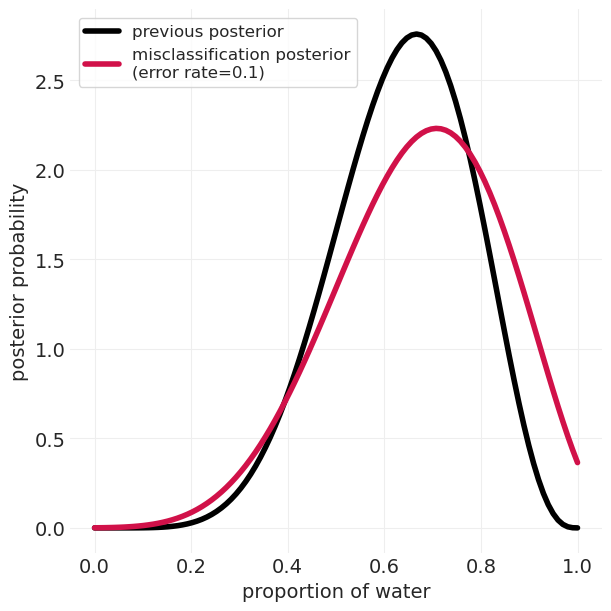

In [48]:
def calculate_unnormalized_n_ways_possible_with_error(p: float, n_W: int, n_L: int, error_rate: float=0.1) -> float:
    n_W_error = (p * (1 - error_rate) + ((1 - p) * error_rate)) ** n_W 
    n_L_error = ((1 - p) * (1 - error_rate) + (p * error_rate)) ** n_L
    return n_W_error * n_L_error

a, b = 6, 3
resolution = 100
proportions = np.linspace(0, 1, resolution)
error_rate = 0.1
error_posterior = np.array(
    [
        calculate_unnormalized_n_ways_possible_with_error(p, a, b, error_rate) for p in proportions
    ]
)
beta_posterior_values = beta_posterior(a, b, proportions)

# Infer normalization constant Z directly from samples
error_posterior *= resolution / error_posterior.sum()
beta_posterior_values *= resolution / beta_posterior_values.sum()

plt.subplots(figsize=(6, 6))
plt.plot(proportions, beta_posterior_values, label='previous posterior', color='k', linewidth=4)
plt.plot(proportions, error_posterior, label=f'misclassification posterior\n(error rate={error_rate:1.2})', linewidth=4)
plt.xlabel("proportion of water")
plt.ylabel("posterior probability")
plt.legend();

## Measurement Matters
- better to model measurement error than to ignore it
- same goes for mssing data
- what matters is _why_ samples differ, and that we are explicit about how model it